# 密度矩阵/混合态的含时动力学演化的量子变分算法

## 概述
纯态可以被表示为一系列本征态的线性叠加，它描述的是与外界环境彻底隔绝地、或者与一个时间无关的外界势场相互作用的系统，因此纯态的波函数演化遵循含时薛定谔方程；而混合态描述了系统与外界环境（噪声、热浴等）耦合的情况，混合态无法用一个波函数表示，其数学表示为密度矩阵。密度矩阵的时间演化遵循量子刘维尔方程，其动力学过程也被称为开放系统的动力学。与含时薛定谔方程不同的是，密度矩阵的时间演化是非酉的，然而量子计算机中的门操作都是酉矩阵，因此需要设计巧妙的量子电路对其进行求解。结合本篇教程，可以自然地推广至虚时演化的方案，虚时演化被用来获取吉布斯态，它描述了体系的微观状态的玻尔兹曼热布居。

本教程的主要内容包括如下几个部分：

- 含时变分原理介绍
- 利用纯化的方法得到密度矩阵，以及求解密度矩阵之间的重叠积分
- 利用mindquantum实现密度矩阵的（非酉）时间演化，求解主方程
- Ising模型的Lindblad主方程求解实例


## 含时变分原理
密度矩阵$\rho$的开放系统演化方程的一般形式为：

$$
\frac{d\rho}{dt}=\mathcal{L}(\rho), 
$$

$\mathcal{L}$被称作超算符（super-operator)，它的一般表达式为$\mathcal{L}=\sum_i g_i S_i\rho T_i^\dagger$，其中$g_i$为系数，$S_i$与$T_i^\dagger$为酉算符。我们将$\rho$参数化为$\rho(\vec{\theta}(t))$，其中$\vec{\theta}=[\theta_1,\theta_2,\cdots]$。根据McLachlan含时变分原理，我们需要
$$
\delta||\sum_i \frac{\partial \rho(\vec{\theta}(t))}{\partial \theta_i}\dot{\theta}_i-\mathcal{L}(\rho)||=0,\dot{\theta}_i=\frac{d\theta_i}{d t}
$$

这本质上是将实际上$\rho$对时间的导数投影到切空间中，切空间为我们所选定的拟设可以表示的空间，即$\{\frac{\partial \rho(\vec{\theta}(t))}{\partial \theta_i}\}$所张成的空间。基于此，我们得到

$$
\sum_{j} M_{i, j} \dot{\theta}_{j}=V_{i}	
$$

$$
M_{i,j}=\textrm{Tr}\left[\left(\frac{\partial \rho(\vec{\theta}(t))}{\partial \theta_i}\right)^\dagger\frac{\partial \rho(\vec{\theta}(t))}{\partial \theta_j}\right]
$$

$$
	V_i = \textrm{Tr}\left[\left(\frac{\partial \rho(\vec{\theta}(t))}{\partial \theta_i}\right)^\dagger \mathcal{L}(\rho)\right]
$$
我们将设计量子线路求解$M_{i,j}$与$V_i$，然后利用经典算法求线性方程得到各个$\theta$对时间的导数。$M_{i,j}$与$V_i$可以写为一个一般的表达式，即$\textrm{Tr}[\rho_1\rho_2]$。

## 通过纯化得到混合态的密度矩阵表示

我们无法将一个系统S对应的混合态用一个波函数进行表示，但可以通过引入一个辅助空间A对其进行纯化，从而可以用一个波函数$|\psi_{\textrm{AS}}\rangle$描述这个扩大的空间。S部分对应的密度矩阵即
$$
\rho_S = \textrm{Tr}_{\textrm{A}}|\psi_{\textrm{AS}}\rangle\langle\psi_{\textrm{AS}}|
$$

这里给一个简单的例子进行说明。q$_0$是引入的辅助比特, q$_1$对应于我们真正感兴趣的物理系统的比特。通过将扩大空间的密度矩阵对辅助空间求`Trace`，我们可以得到物理系统对应的约化密度矩阵$\rho=0.995|0\rangle\langle 0|+0.0497i|0\rangle\langle 1|-0.0497i|1\rangle\langle 0|+ 0.00498|1\rangle\langle 1|$，显然，量子比特q$_1$的状态并不是一个纯态（若为纯态，则$\rho$的非对角元应为0，对角元代表混合态在不同基矢的占据，非对角元代表基矢间的相干）。

In [66]:
from mindquantum import Circuit, RX, H, X
import numpy as np
circ = Circuit()
circ += H.on(0)
circ += RX(0.2).on(1, 0)
circ.svg()

In [68]:
psi = circ.get_qs()
# mindquantum的开发后续可依下面的逻辑，对部分qubit求partial trace来得到混合态的密度矩阵
psi = psi.reshape(2, 2)
rho = np.tensordot(psi, psi.conj(), axes=(1, 1))
print(rho)

[[0.99501664+0.j         0.        +0.04966733j]
 [0.        -0.04966733j 0.00498336+0.j        ]]


## 设计量子线路计算两个密度矩阵的重叠积分：$\textrm{Tr}[\rho_1\rho_2]$

在了解了纯化的原理以后，我们现在尝试计算密度矩阵的重叠积分$\textrm{Tr}[\rho_1\rho_2]$。不妨假设最为一般的表达式
$$
\rho_1 = \textrm{Tr}_{\textrm{A}}\left[U_1 |\psi_{\textrm{AS}}\rangle\langle\psi_{\textrm{AS}}|U_2^\dagger\right]
$$
$$
\rho_2 = \textrm{Tr}_{\textrm{A}}\left[U_3 |\psi_{\textrm{AS}}\rangle\langle\psi_{\textrm{AS}}|U_4^\dagger\right]
$$
$$
\textrm{Tr}[\rho_1\rho_2] = \textrm{Tr}_{\textrm{S}}[\rho_1\rho_2]
$$
这里我们依然采用$|\psi_{\textrm{AS}}\rangle$来表示扩大空间（辅助空间A+物理空间S）的波函数。我们用a标记$\rho_1$对应的量子线路中所有的物理比特，用b标记$\rho_1$对应的量子线路中所有的辅助比特；用c标记$\rho_2$对应的量子线路中所有的物理比特，用d标记$\rho_1$对应的量子线路中所有的辅助比特。除此之外，我们再额外引入一个辅助比特$\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$作测量。
接下来，我们需要首先构造出
$$
\frac{1}{\sqrt{2}}|0\rangle U_1|\psi_{\textrm{AS}}\rangle U_3|\psi_{\textrm{AS}}\rangle+\frac{1}{\sqrt{2}}|1\rangle U_2|\psi_{\textrm{AS}}\rangle U_4 |\psi_{\textrm{AS}}\rangle.
$$
该式可以被展开为：
$$
\sum_{abcd}\frac{1}{\sqrt{2}}|0\rangle C_1^{ab}C_3^{cd}|abcd\rangle+\frac{1}{\sqrt{2}}|1\rangle C_2^{ab}C_4^{cd}|abcd\rangle
$$
接下来将$\rho_1$与$\rho_2$部分对应的物理比特进行control-swap:
$$
\sum_{abcd}\frac{1}{\sqrt{2}}|0\rangle C_1^{ab}C_3^{cd}|abcd\rangle+\frac{1}{\sqrt{2}}|1\rangle C_2^{cb}C_4^{ad}|abcd\rangle
$$
最后我们在对测量比特做一个Hadamard门，
$$
\sum_{abcd}\frac{1}{2}|0\rangle (C_1^{ab}C_3^{cd}+ C_2^{cb}C_2^{ad})|abcd\rangle+\frac{1}{2}|1\rangle (C_1^{ab}C_3^{cd}- C_2^{cb}C_4^{ad})|abcd\rangle
$$
$$
P_0 -P_1= \sum_{abcd}\textrm{Re}[C_1^{ab}C_2^{cb*}C_3^{cd}C_4^{ad*}]
$$
显然测量$P_0-P_1$就等于我们要求的$\textrm{Tr}[\rho_1\rho_2]$的实部：
$$
\textrm{Re}\textrm{Tr}_S[(\textrm{Tr}_A U_1|\psi_{\textrm{AS}}\rangle\langle \psi_{\textrm{AS}}|U_2^\dagger)(\textrm{Tr}_AU_3|\psi_{\textrm{AS}}\rangle\langle \psi_{\textrm{AS}}|U_4^\dagger)]
$$
若要求解虚部，则在测量比特第一个Hadamard门之后施加一个S dagger门即可，具体可见下文。

## 开放系统动力学实例：Ising模型的主方程求解
对于一个2个自旋格点的Ising模型，哈密顿量为
$$
H=X_0+X_1+\frac{1}{4}Z_0Z_1
$$
其主方程为：
$$
\frac{d}{dt}\rho=-i[H,\rho]+\sum_{j=0}^1 \mathcal{L}_j(\rho)
$$
$$
\mathcal{L}_j(\rho)=\frac{1}{2}\{2\sigma_j^-\rho\sigma_j^+-\sigma_j^+\sigma_j^-\rho-\rho\sigma_j^+\sigma_j^-\}
$$
$t=0$时将所有$\theta$设置为为，初始状态对应于一个纯态$|00\rangle$的密度矩阵
$$
\rho_0=|00\rangle\langle 00|
$$
接下来，我们将展示如何演化这一主方程。

首先，设计$\rho$的量子线路Ansatz如下，其中q$_2$与q$_3$为要研究的自旋格点对应的物理比特，q$_0$与q$_1$为引入的辅助比特，该Ansatz共由6个参数（$\theta_0,\theta_1,\cdots,\theta_5$）控制。

In [188]:
from mindquantum import Circuit, RX, RZ, H, X, Y, Z, S
from mindquantum.core.gates import SWAP
from mindquantum.core.gates import Measure
from mindquantum.simulator import Simulator    # 从mindquantum.simulator中导入Simulator类
import numpy as np
from scipy import linalg

circ = Circuit()

operations = [H.on(0), H.on(1), RX("theta0").on(2, 0), RX("theta1").on(3, 1),
             X.on(3, 2), RZ("theta2").on(3), X.on(3, 2), RX("theta3").on(2),
             RX("theta4").on(3), X.on(3, 2), RZ("theta5").on(3), X.on(3, 2), ]
for i_op in operations:
    circ += i_op
circ.svg()

接下来主要是通过量子线路求解$M_{i,j} (0\le i,j\le 5)$以及$V_{i} (0\le i\le 5)$
$$
\sum_{j} M_{i, j} \dot{\theta}_{j}=V_{i}	
$$

$$
M_{i,j}=\textrm{Tr}\left[\left(\frac{\partial \rho(\vec{\theta}(t))}{\partial \theta_i}\right)^\dagger\frac{\partial \rho(\vec{\theta}(t))}{\partial \theta_j}\right]
$$

$$
	V_i = \textrm{Tr}\left[\left(\frac{\partial \rho(\vec{\theta}(t))}{\partial \theta_i}\right)^\dagger \mathcal{L}(\rho)\right]
$$

令
$$
\frac{\partial \rho(\vec{\theta}(t))}{\partial \theta_j}=-iA+iA^\dagger, \frac{\partial \rho(\vec{\theta}(t))}{\partial \theta_i}=-iB+iB^\dagger
$$
则可导出（此处省略推导）：
$$
\textrm{Tr}\left[\left(\frac{\partial \rho(\vec{\theta}(t))}{\partial \theta_i}\right)^\dagger\frac{\partial \rho(\vec{\theta}(t))}{\partial \theta_j}\right]=2\textrm{Re}\textrm{Tr}[B^\dagger A]-2\textrm{Re}\textrm{Tr}[BA]
$$

下面为求解$M_{i,j}$的量子线路，其中`thetas`为描述线路的参数向量（$[\theta_0,\theta_1,\cdots, \theta_5]$），`theta_i`与`theta_j`的取值范围为0~5，`qcidx`取$0$或$1$，分别对应于上式中的两项：$\textrm{Re}\textrm{Tr}[B^\dagger A], \textrm{Re}\textrm{Tr}[BA]$。

In [124]:
def make_circ_m(thetas, theta_i, theta_j, qcidx):
    assert qcidx in [0, 1]
    circ = Circuit()
    circ += H.on(0)
    circ += H.on(1)
    circ += H.on(2)
    circ += H.on(5)
    circ += H.on(6)
    
    apply_dic = {0: [RX(thetas[0]).on(3, 1)],
                 1: [RX(thetas[1]).on(4, 2)],
                 2: [X.on(4, 3), RZ(thetas[2]).on(4), X.on(4, 3)],
                 3: [RX(thetas[3]).on(3)],
                 4: [RX(thetas[4]).on(4)],
                 5: [X.on(4, 3), RZ(thetas[5]).on(4), X.on(4, 3)]
                }

    
    for i in range(6):
        if i == theta_i:
            if qcidx == 1:
                circ += X.on(0)
            if i in [0, 1]:
                circ += X.on(i+3, (0, i+1))
            elif i in [2, 5]:
                circ += Z.on(3, 0)
                circ += Z.on(4, 0)
            else:
                circ += X.on(i, 0)
            if qcidx == 1:
                circ += X.on(0)
        
        for i_op in apply_dic[i]:
            circ += i_op
            
    apply_dic = {0: [RX(thetas[0]).on(7, 5)],
                 1: [RX(thetas[1]).on(8, 6)],
                 2: [X.on(8, 7), RZ(thetas[2]).on(8), X.on(8, 7)],
                 3: [RX(thetas[3]).on(7)],
                 4: [RX(thetas[4]).on(8)],
                 5: [X.on(8, 7), RZ(thetas[5]).on(8), X.on(8, 7)]
                }
    
    for i in range(6):
        if i == theta_j:
            circ += X.on(0)
            if i in [0, 1]:
                circ += X.on(i+7, (0, i+5))
            elif i in [2, 5]:
                circ += Z.on(7, 0)
                circ += Z.on(8, 0)
            else:
                circ += X.on(i+4, 0)
            circ += X.on(0)
        for i_op in apply_dic[i]:
            circ += i_op
    circ += SWAP.on((3, 7), 0)
    circ += SWAP.on((4, 8), 0)
    circ += H.on(0)
    return circ

作为示例，可以看一下求解$M_{1, 2}$的第一项的量子线路：

In [214]:
circ = make_circ_m(thetas, 1, 2, 0)
circ.svg()

`mindquantum`内置了量子线路的测量方案，依然以上图中所示的线路为例：

In [225]:
circ = make_circ_m(thetas, 1, 2, 0)
circ += Measure('q0').on(0) 
sim = Simulator('mqvector', 9)
sim.reset()
result = sim.sampling(circ, shots=1000) 
res = result.data
print(res)

{'0': 535, '1': 465}


我们也可以不用采样的方法，直接利用矩阵乘法拿到精确的”测量值“：

In [226]:
circ = make_circ_m(thetas, 1, 2, 0)
vec = circ.get_qs()
vec = vec.reshape(-1, 2)
res = np.einsum("ab, ab -> b", np.conj(vec), vec).real
print(res)

[0.53349583 0.46650417]


这么做的好处是相当节省时间，第一种做采样的方法如果采100000次可能需要10分钟，而第二种方法可以瞬间完成。

$V_i$的求解会更为繁琐一些，因为涉及到$\mathcal{L}(\rho)$的项数较多：
$$
\mathcal{L}(\rho)=-iH\rho+i\rho H+\frac{1}{2}(2\sigma_0^-\rho\sigma_0^+-\sigma_0^+\sigma_0^-\rho-\rho\sigma_0^+\sigma_0^-)+\frac{1}{2}(2\sigma_1^-\rho\sigma_1^+-\sigma_1^+\sigma_1^-\rho-\rho\sigma_1^+\sigma_1^-)
$$
进一步展开：
$$
\mathcal{L}(\rho)=(-iX_0-iX_1-\frac{i}{4}Z_0Z_1)\rho+\rho(iX_0+iX_1+\frac{i}{4}Z_0Z_1)\\ + (-\frac{i}{4}X_0Y_0-\frac{i}{4}X_1Y_1)\rho+\rho(-\frac{i}{4}X_0Y_0-\frac{i}{4}X_1Y_1)\\+\frac{1}{4}(X_0\rho X_0+X_1\rho X_1+Y_0\rho Y_0+Y_1\rho Y_1)\\+
\frac{i}{4}(X_0\rho Y_0-Y_0\rho X_0+X_1\rho Y_1-Y_1\rho X_1)\\-\rho
$$
在这里只举其中几项的求解为例进行说明，其余的依照相同的逻辑可以得到。
$$
\textrm{Tr}\left[\left(\frac{\partial \rho(\vec{\theta}(t))}{\partial \theta_i}\right)^\dagger(-iX_0\rho)\right]+\textrm{Tr}\left[\left(\frac{\partial \rho(\vec{\theta}(t))}{\partial \theta_i}\right)^\dagger(i\rho X_0)\right]=-2\textrm{Re}\textrm{Tr}[BX_0\rho]+2\textrm{Re}\textrm{Tr}[B\rho X_0]
$$
$$
\textrm{Tr}\left[\left(\frac{\partial \rho(\vec{\theta}(t))}{\partial \theta_i}\right)^\dagger(X_0\rho X_0)\right]=2\textrm{Im}\textrm{Tr}BX_0\rho X_0
$$
其中，
$$
\frac{\partial \rho(\vec{\theta}(t))}{\partial \theta_i}=-iB+iB^\dagger
$$
这里不再展示求其中单独某一项的量子电路，其思路与前面求解$M$矩阵是一致的，对于虚部的求解需要做一些微调。你可以在`mindquantum/tutorials/source`中找到所有的代码。

最后，我们可以模拟实时间的动力学行为，在这里直接调用包含所有线路测量的程序`dynamics.py`。

In [219]:
from dynamics import *

Text(0, 0.5, '$\\langle Z_0\\rangle$')

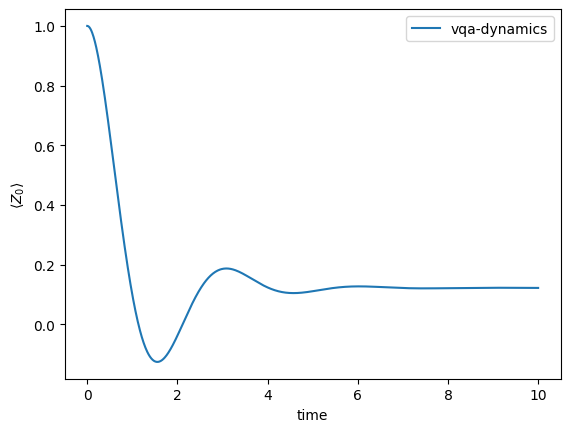

In [222]:
thetas = [0] * 6
z0 = [measure_z0(thetas)]
for i in range(1000):
    grads = get_grad(thetas) #给定thetas，得到thetas关于时间的导数
    grads = [igrad * 2 for igrad in grads]
    thetas = [np.real(thetas[j]+grads[j]*0.01) for j in range(len(grads))]
    z0.append(measure_z0(thetas))
fig, axes = plt.subplots()
plt.plot(np.arange(0, 10.01, 0.01), z0, label='vqa-dynamics')
axes.legend()
axes.set_xlabel("time")
axes.set_ylabel(r"$\langle Z_0\rangle$")